# Setup
General setup and imports

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error as mse

%matplotlib inline
import seaborn as sns;
sns.set(style="ticks", color_codes=True)


# 1.1 Cleaning Data
***
## 1.1.1
Aggregate routes on the same date, summing attempts and successes, and recalculate success percentages.
Also remove invalid values for success percentages:

In [2]:
# Read climbing statistics csv
climb = pd.read_csv('climbing_statistics.csv')

# Group identical rows of Data and Route, and sum aggregate relevant columns
climb = climb.groupby(['Date','Route'], as_index=False).sum()

# Calculate success percentage for each row
climb['Success Percentage'] = climb.apply(lambda x: x['Succeeded'] / x['Attempted'], axis=1)

# Drop rows with invalid success percentage
climb = climb.drop(climb[climb['Success Percentage'] > 1].index)

climb.head()

,Date,Route,Attempted,Succeeded,Success Percentage
0,1/16/2014,Little Tahoma,2,0,0.0
1,1/18/2014,Gibralter Ledges,8,4,0.5
2,1/19/2014,Gibralter Ledges,2,0,0.0
3,1/20/2014,Fuhrer's Finger,2,0,0.0
4,1/23/2014,Little Tahoma,2,0,0.0


## 1.1.2
Drop irrelevant weather columns:

In [3]:
# Read weather data csv
weather = pd.read_csv('Rainier_Weather.csv')

# Drop Irrelevant columns
weather = weather.drop(['Battery Voltage AVG'], axis=1)
weather.head()

,Date,Temperature AVG,Relative Humidity AVG,Wind Speed Daily AVG,Wind Direction AVG,Solar Radiation AVG
0,12/31/2015,19.062917,21.870833,21.977792,62.325833,84.915292
1,12/30/2015,14.631208,18.493833,3.540542,121.505417,86.192833
2,12/29/2015,6.614292,34.072917,0.000000,130.291667,85.100917
3,12/28/2015,8.687042,70.557917,0.000000,164.683750,86.241250
4,12/27/2015,14.140417,95.754167,0.000000,268.479167,31.090708


## 1.1.3
Here, the columns from the weather data are applied to the climb data by matching each row's date with the correct row from the weather data.

Climbs with no matching weather data are dropped:

In [4]:
def match_date(row, column_name):
    ''' 
    Locate the row in weather data matching the date from input row.
    Returns nan if date is not found in weather data.
    
    '''
    try:
        return weather[weather['Date'] == row['Date']][column_name].iloc[0]
    except IndexError:
        return np.nan
    

# First, convert all dates to datetime objects
climb['Date'] =  pd.to_datetime(climb['Date'], format='%m/%d/%Y')
weather['Date'] =  pd.to_datetime(weather['Date'], format='%m/%d/%Y')

# Apply lambda to each row of climb data with correct weather data
weather_columns = weather.columns.drop('Date')
for column in weather_columns:
    climb[column] = climb.apply(lambda x: match_date(x, column), axis=1)

# Drop rows without corresponding weather data
climb = climb.dropna()

# Sort by date
climb = climb.sort_values('Date')
climb = climb.reset_index(drop=True)
climb.head()

,Date,Route,Attempted,Succeeded,Success Percentage,Temperature AVG,Relative Humidity AVG,Wind Speed Daily AVG,Wind Direction AVG,Solar Radiation AVG
0,2014-09-23,Disappointment Cleaver,11,0,0.000000,32.857333,100.000000,65.110667,254.273333,16.593800
1,2014-09-24,Disappointment Cleaver,12,0,0.000000,29.702917,100.000000,45.915000,278.054167,37.873708
2,2014-09-25,Disappointment Cleaver,14,8,0.571429,26.823750,99.854167,3.166208,278.604167,142.698917
3,2014-09-26,Disappointment Cleaver,41,19,0.463415,28.238333,100.000000,0.897625,259.645833,114.400833
4,2014-09-27,Disappointment Cleaver,44,25,0.568182,33.318750,60.200417,7.140917,116.294583,227.597125


# 1.2
***
## 1.2.1
The climbing statistics are plotted over time. It can be seen the majority of climbs are during the Summer months. It seems like the climbs between Feb 15' and May 15' have low success rates, and during Summer it is more variable:

/home/leon/Desktop/ic/M3A50/projects/python/env/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


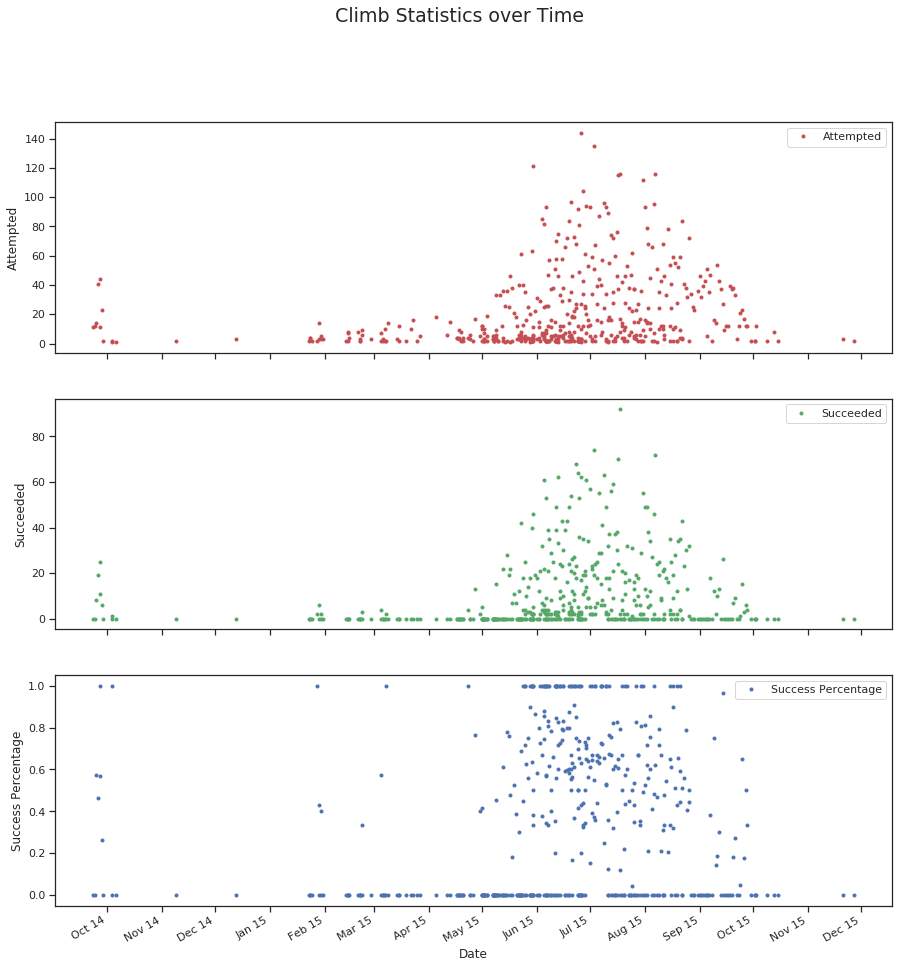

In [5]:
# Format dates
years = mdates.YearLocator()
months = mdates.MonthLocator()
months_fmt = mdates.DateFormatter('%b %y')

# Plot statistics over time
fig, axes = plt.subplots(3,1, figsize=(15,16))
columns = ['Attempted', 'Succeeded', 'Success Percentage']
colors = ['r', 'g', 'b']
for i, column in enumerate(columns):
    ax = axes[i]
    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(months_fmt)
    
    ax.plot_date(climb['Date'], climb[column], ms=3, label=column, color=colors[i])
    ax.set_xlabel('Date')
    ax.set_ylabel(column)
    ax.legend()

fig.suptitle('Climb Statistics over Time', fontsize=19)
fig.autofmt_xdate()
plt.show()

## 1.2.2
Now, the weather variables are plot over time. There seems to be some correlation between the temperature and solar radiation, which may affect the quality of the regression methods later on because of colinearity between these predictors:

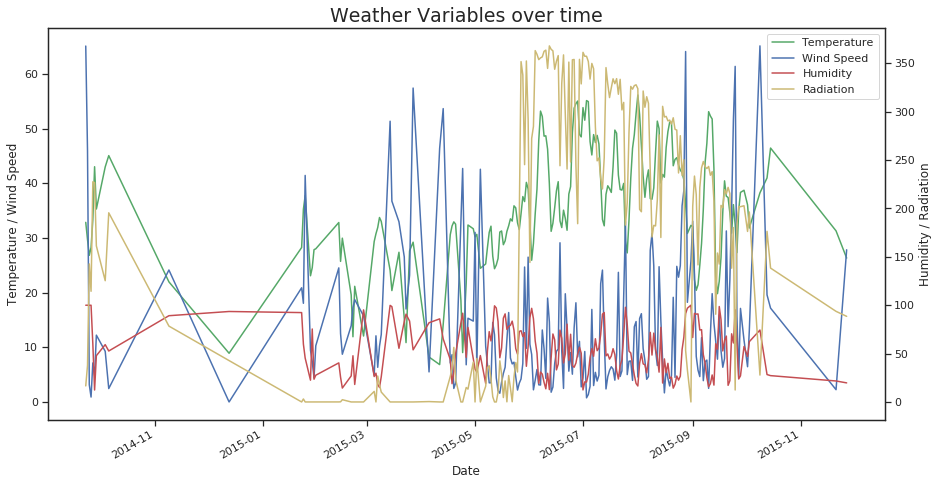

In [6]:
fig, ax1 = plt.subplots(figsize=(15,8))
ax2 = ax1.twinx()

ax1.xaxis.set_major_locator(months)
ax1.xaxis.set_major_formatter(months_fmt)

ln1 = ax1.plot_date(climb['Date'], climb['Temperature AVG'], 'g-', label='Temperature')
ln2 = ax1.plot_date(climb['Date'], climb['Wind Speed Daily AVG'], 'b-', label='Wind Speed')
ln3 = ax2.plot_date(climb['Date'], climb['Relative Humidity AVG'], 'r-', label='Humidity')
ln4 = ax2.plot_date(climb['Date'], climb['Solar Radiation AVG'], 'y-', label='Radiation')

lns = ln1 + ln2 + ln3 + ln4
labs = [l.get_label() for l in lns]
ax1.set_title('Weather Variables over time', fontsize=19)
ax1.set_xlabel('Date')
ax1.set_ylabel('Temperature / Wind Speed')
ax2.set_ylabel('Humidity / Radiation')
ax1.legend(lns, labs, loc=0)
fig.autofmt_xdate()

plt.show()

## 1.2.3
Histograms of the weather variables are now plotted (across two x axes), using 50 bins per weather variable and allowing us to roughly see the distributions for each variable:

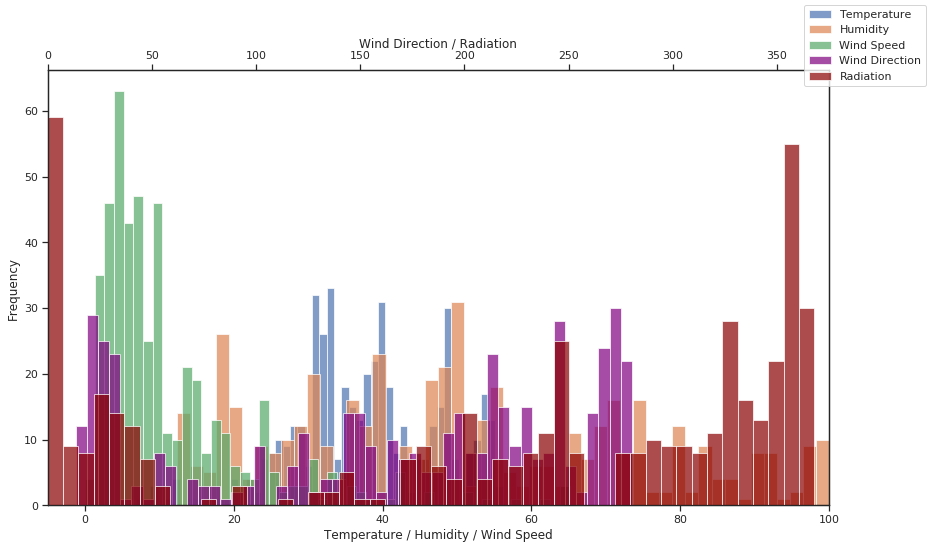

In [7]:
fig, ax1 = plt.subplots(figsize=(14,8))
ax2 = ax1.twiny()

ax1.hist(climb['Temperature AVG'], bins=50, label='Temperature', alpha=0.7)
ax1.hist(climb['Relative Humidity AVG'], bins=50, label='Humidity', alpha=0.7)
ax1.hist(climb['Wind Speed Daily AVG'], bins=50, label='Wind Speed', alpha=0.7)
ax2.hist(climb['Wind Direction AVG'], bins=50, label='Wind Direction', color='purple', alpha=0.7)
ax2.hist(climb['Solar Radiation AVG'], bins=50, label='Radiation', color='darkred', alpha=0.7)

ax1.set_xlim([-5, 100])
ax2.set_xlim([0, 375])

ax1.set_ylabel('Frequency')
ax1.set_xlabel('Temperature / Humidity / Wind Speed')
ax2.set_xlabel('Wind Direction / Radiation')
fig.legend()
plt.show()

# 1.3
***
A function is written to show scatter plots between variables. From these plots, a few things can be observed:

- Temperature and Humidity seem to be slightly negatively correlated
- Temperature and Solar Radiation seem to be slightly positively correlated, which makes sense since both are driven by amount of sun exposure
- Wind direction and Wind speed seem to have some non-linear relationship

The presence of correlation between predictors (multicollinearity) can lead to problems in model that has been fit on these predictors. Removing/reducing highly correlated variables through regularization can be beneficial, since it can reduce the variance of the model through a small increase in the bias. This can reduce the MSE of out-of-sample predictions. In this case, it might be useful to consider regulization since the temperature and humidity variables seem to be correlated to a significant level.

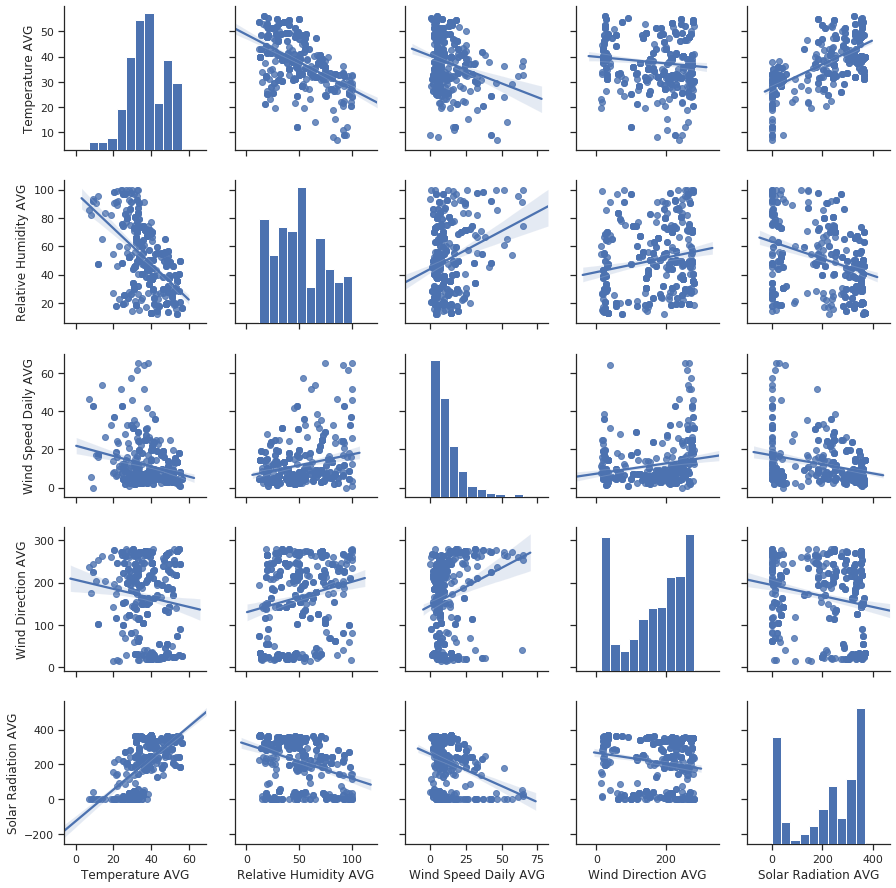

In [8]:
def pair_scatter(df, columns):
    sns.pairplot(df[columns], kind="reg")

pair_scatter(climb, list(weather_columns))

# 1.4
A function is written to divide the data into a train and validation set. To ensure similar distributions between the train and validation sets, the data is divided into 10 bins according to Success Percentage, then split 80/20 for each bin randomly. Using the histograms below, we make sure that we have similar distributions for the success percentage so that the data is well sampled:

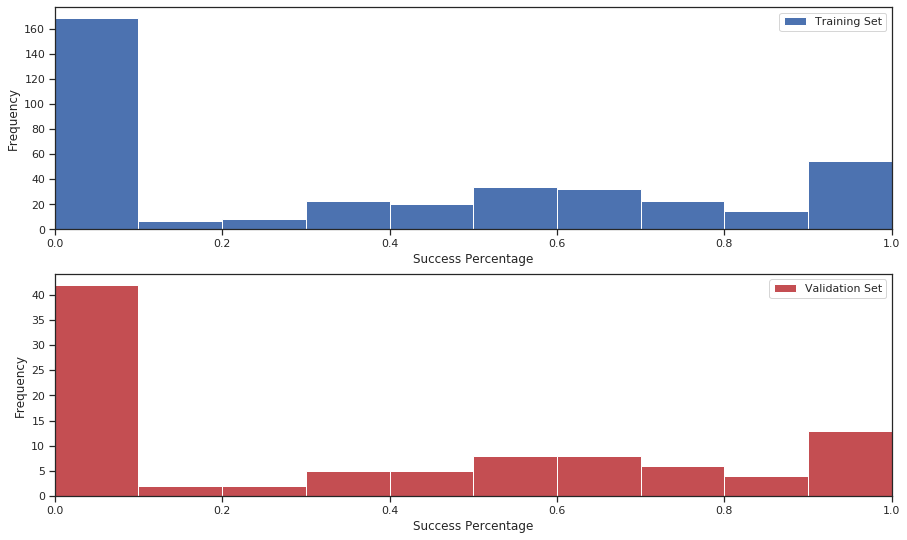

train:validation
80.2:19.8


In [9]:
def split_data(df, train_size):
    # Split data up into 10 bins according to Success Percentage
    bins = np.arange(0, 1.1, 0.1)#, dtype=float)
    bins[0] = -0.001
    train = pd.DataFrame(columns = df.columns)
    validation = pd.DataFrame(columns = df.columns)
    for i in range(len(bins) - 1):
        
        # Filter dataframe for bin
        df2 = df[(df['Success Percentage'] > bins[i]) & (df['Success Percentage'] <= bins[i+1])]
        df2 = df2.reset_index(drop=True)
        
        # Allocate 80/20 split
        train_temp = df2.sample(frac=train_size, random_state=6)
        validation = validation.append(df2.drop(train_temp.index))
        train = train.append(train_temp)
    return train, validation

train, validation = split_data(climb, 0.8)

# Plot distributions of success percentages across train and validation sets
fig, axes = plt.subplots(2, 1, figsize=(15,9))
axes[0].hist(train['Success Percentage'], bins=10, label='Training Set')
axes[0].set_xlim([0, 1])
axes[1].hist(validation['Success Percentage'], bins=10, label='Validation Set', color='r')
axes[1].set_xlim([0, 1])
axes[0].set_xlabel('Success Percentage')
axes[1].set_xlabel('Success Percentage')
axes[0].set_ylabel('Frequency')
axes[1].set_ylabel('Frequency')
axes[0].legend()
axes[1].legend()
plt.show()

# Check sizes
split = 100 * round(len(train) / (len(train) + len(validation)), 3)
split2 = round(100-split, 3)
print('train:validation')
print(f'{split}:{split2}')

# 2.1
***
## 2.1.1
A Linear Regression model is fit to the training data to predict the Success Percentage. The data is first scaled to improve the interpretability of the output parameters. Using the model trained on the training set from before, the Success Percentages are predicted for the training, validation and tests sets. Also, the MSE is calculated for the training and validation sets.

In [10]:
weather_predictors = weather_columns.drop('Wind Direction AVG')
X_train = train[weather_predictors]
y_train = train['Success Percentage']

# Rescale training data between 0 and 1
scaler = sklearn.preprocessing.MinMaxScaler()
scaler = scaler.fit(X_train[weather_predictors])
X_train_scaled = X_train.copy()
X_train_scaled[weather_predictors] = scaler.transform(X_train_scaled[weather_predictors])

# Fit linear model on training set
linear_model = LinearRegression()
linear_model.fit(X_train_scaled, y_train)
params_linear = np.insert(linear_model.coef_, 0, linear_model.intercept_)
names = list(np.insert(weather_columns.drop('Wind Direction AVG'), 0, 'Intercept'))
print(f'Predictors: {names}')
print(f'Predictor Weights: {params_linear}')

# Predict in-sample success percentage using trained model
y_train_pred = linear_model.predict(X_train_scaled)

# Compute in-sample error
mse_train_linear = mse(y_train_pred, y_train)
print(f'Training set MSE: {round(mse_train_linear, 3)}')

Predictors: ['Intercept', 'Temperature AVG', 'Relative Humidity AVG', 'Wind Speed Daily AVG', 'Solar Radiation AVG']
Predictor Weights: [ 0.14078259 -0.10500829  0.02194475 -0.10798865  0.51953468]
Training set MSE: 0.11


Using the model fitted on the training set, the Success Percentage in the validation set is now predicted. We see that the MSE is larger than the in-sample MSE (this is likely, since this data was not seen by the model):

In [11]:
X_validation = validation[weather_predictors]

# Values we are trying to predict
y_validation = validation['Success Percentage']

# Rescale data using scaler from training data
X_validation_scaled = X_validation.copy()
X_validation_scaled[weather_predictors] = scaler.transform(X_validation_scaled[weather_predictors])

# Predict success percentage of validation set using model trained on training set
y_validation_pred = linear_model.predict(X_validation_scaled)

# Compute validation set error
mse_validation_linear = mse(y_validation_pred, y_validation)
print(f'Validation set MSE: {round(mse_validation_linear, 3)}')

Validation set MSE: 0.121


Now predict the test set Success Percentages:

In [12]:
# Read in test set csv
test = pd.read_csv('test_set.csv')
X_test = test[weather_predictors]

# Rescale data using scaler from training data
X_test_scaled = X_test.copy()
X_test_scaled[weather_predictors] = scaler.transform(X_test_scaled[weather_predictors])

# Predict success percentage of test set
y_test_pred_linear = linear_model.predict(X_test_scaled)
print(f'Test set predicted Success Percentages: {y_test_pred_linear}')

Test set predicted Success Percentages: [0.25803384 0.31803995 0.32356366 0.33484161]


## 2.1.2 / 2.1.3
Now a model is fit to the training set using ridge regression. We fit the model for a range of penalty parameters and plot the in-sample and out-of-sample MSEs against the penalty parameter.

After fitting the model, a graph is plotted showing how the MSE changes with the penalty parameter. For low values of alpha, the model is fit like the an ordinary linear model, with nearly the same MSE values. As the penalty parameter increase, the in-sample MSE increases.

In the **out-of-sample** MSE plot however, the MSE can be seen to decrease for some values of alpha. This is due to the bias-variance trade off - the penalty term forces some predictors to decrease in size. This increases the bias of the model but reduces the variance, which increases the model's ability to generalise. In this case, since the MSE is at a minimum for some value of alpha around 10, this tradeoff seems to be beneficial for predicting the out-of-sample Success Percetages. The alpha that gives the lowest MSE for the validation set is chosen (denoted alpha_star).

***
The second plot shows how the size of the parameters are changed as alpha increases. Firstly, since the predictors have been normalised, the relative magnitude of the predictors reflects their significance. Ie. a high solar radiation means a significantly higher success probability of a climb. In the first portion of the graph where alpha is increased from 0.01, the parameters for radiation and temperature decrease and increase respectively. This can be explained by the fact that radiation and temperature are positively correlated. This in turn is likely to decrease the variance of the model (and increase the bias) as seen in the previous explanations and plots.

alpha_star: 10.975


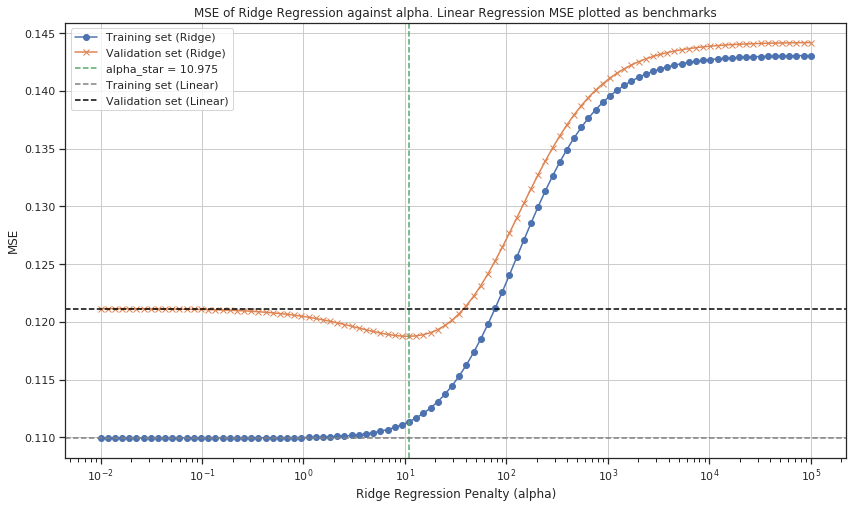

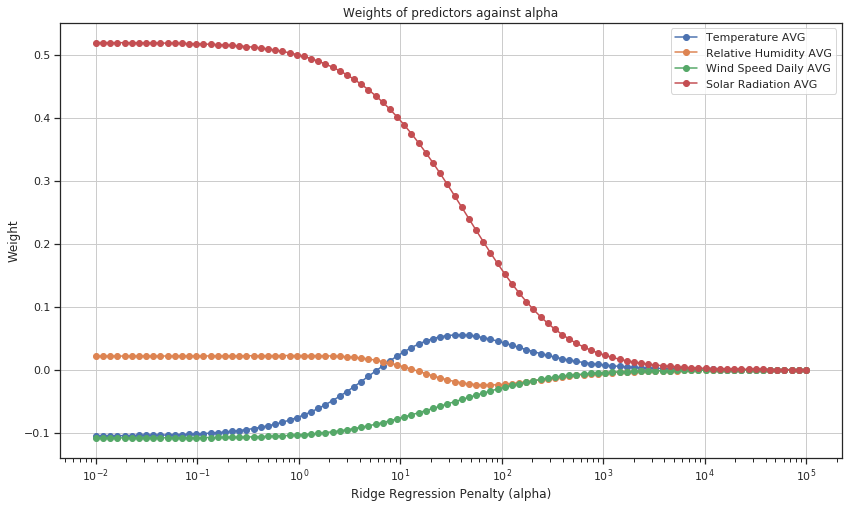

In [13]:
# Perform ridge regression on training set
# Set up set of alphas to use (penalty parameters)
alphas = np.logspace(-2, 5, 100)
ridge_models = [None] * len(alphas)
mses_train_ridge = np.zeros(len(alphas))
mses_validation_ridge = np.zeros(len(alphas))
parameters = []

# Train ridge regression models for each alpha
for n, alpha in enumerate(alphas):
    ridge_models[n] = Ridge(alpha=alpha)
    ridge_models[n].fit(X_train_scaled, y_train)

    # Predict test and validation set success percentage
    y_train_pred = ridge_models[n].predict(X_train_scaled)
    y_validation_pred = ridge_models[n].predict(X_validation_scaled)
    
    # Compute test and validation errors
    mses_train_ridge[n] = mse(y_train_pred, y_train)
    mses_validation_ridge[n] = mse(y_validation_pred, y_validation)
    
    parameters.append(ridge_models[n].coef_)

# Plot graph of MSE and alpha
fig, ax1 = plt.subplots(figsize=(14,8))
ax1.plot(alphas, mses_train_ridge, label='Training set (Ridge)', marker='o')
ax1.plot(alphas, mses_validation_ridge, label='Validation set (Ridge)', marker='x')
ax1.set_xscale('log')
plt.xlabel('Ridge Regression Penalty (alpha)')
plt.ylabel('MSE')

# Calculate alpha that gives lowest validation MSE
index = np.argmin(mses_validation_ridge)
alpha_star = alphas[index]
mse_train_ridge = mses_train_ridge[index]
mse_validation_ridge = mses_validation_ridge[index]
params_ridge = np.insert(ridge_models[index].coef_, 0, ridge_models[index].intercept_)
print(f'alpha_star: {round(alpha_star, 3)}')
plt.axvline(x=alpha_star, color='g', linestyle='dashed', label=f'alpha_star = {round(alpha_star, 3)}')
plt.axhline(y=mse_train_linear, color='grey', linestyle='dashed', label=f'Training set (Linear)')
plt.axhline(y=mse_validation_linear, color='black', linestyle='dashed', label=f'Validation set (Linear)')

plt.legend()
plt.grid()
plt.title('MSE of Ridge Regression against alpha. Linear Regression MSE plotted as benchmarks')
plt.show()


# Plot graph of parameters and alpha
fig, ax1 = plt.subplots(figsize=(14,8))
ax1.plot(alphas, parameters, label='Training set (Ridge)', marker='o')
plt.xlabel('Ridge Regression Penalty (alpha)')
plt.ylabel('Weight')
plt.legend(weather_predictors)
ax1.set_xscale('log')
plt.grid()
plt.title('Weights of predictors against alpha')
plt.show()

# Predict success percentage of test set
y_test_pred_ridge = ridge_models[index].predict(X_test_scaled)

### Linear Regression vs Ridge Regression Summary
From the graph of MSE vs alpha, we see that it is optimal to choose to include a penalty on the parameter sizes (alpha_star), in terms of minimising the MSE of the validation set prediction with respect to the penalty parameter. In this case of ridge regression, this is an L2 penalty.

We might favour the regularised ridge model because it is less likely to have overfit based on these results, and it could be expected to perform better on other out-of-sample data. The decreases in out-of-sample MSE from regularisation suggests there is some collinearity that, when accounted for with the regulisation term, can improve the model's out-of-sample predictions over the normal linear regression model.

Below, the test set predictions are shown for each model; they are similar but not identical. The parameters for each model are also shown below. The ridge parameters for Temperature, Humidity and Radiation are significantly different to that of linear regression. This makes sense since these 3 predictors were seen to be correlated in some way, so a different linear combination of these predictors was found by the ridge regression model in a way that increases bias but reduces variance of the model, thereby reducing the MSE for the out-of-sample predictions (the decrease in variance outweighs the increase in bias.) Also, the magnitude of all parameters are lower in the final ridge regression model.

In [14]:
# Predict success percentage of test set (ridge)
y_test_pred_ridge = ridge_models[index].predict(X_test_scaled)

print(f'Linear Model test-set predictions: {y_test_pred_linear}')
print(f'Ridge Regression test-set predictions: {y_test_pred_ridge}')

# Populate table
df_table = pd.DataFrame(columns=['Label', 'Linear Regression', 'Ridge Regression'])
df_table.loc[0] = ['Training set MSE', round(mse_train_linear, 3), round(mse_train_ridge, 3)]
df_table.loc[1] = ['Validation set MSE', round(mse_validation_linear, 3), round(mse_validation_ridge, 3)]
for i in range(len(names)):
    df_table.loc[i+2] = [f'{names[i]} parameter', round(params_linear[i], 3), round(params_ridge[i], 3)]
df_table.loc[7] = ['Penalty Parameter', '', round(alpha_star, 3)]
df_table

Linear Model test-set predictions: [0.25803384 0.31803995 0.32356366 0.33484161]
Ridge Regression test-set predictions: [0.25571258 0.34575805 0.3006777  0.32744883]


,Label,Linear Regression,Ridge Regression
0,Training set MSE,0.11,0.111
1,Validation set MSE,0.121,0.119
2,Intercept parameter,0.141,0.135
3,Temperature AVG parameter,-0.105,0.029
4,Relative Humidity AVG parameter,0.022,0.005
5,Wind Speed Daily AVG parameter,-0.108,-0.075
6,Solar Radiation AVG parameter,0.52,0.389
7,Penalty Parameter,,10.975


# 2.2 - Classification
***
## 2.2.1
The data is unfolded such that each row corresponds to every climb, labelled as a success or failure in the 'Success' column:

In [15]:
train_bin = pd.DataFrame(columns = train.columns)
validation_bin = pd.DataFrame(columns = validation.columns)
train_bin['Success'] = 0
validation_bin['Success'] = 0

for index, row in train.iterrows():
    # Unfold successfull attempts
    for success in range(row['Succeeded']):
        new_row = row
        new_row['Success'] = 1
        train_bin = train_bin.append(row)
        
    # Unfold unsuccessfull attempts
    for failure in range(row['Attempted'] - row['Succeeded']):
        new_row = row
        new_row['Success'] = 0
        train_bin = train_bin.append(row)
        

for index, row in validation.iterrows():
    # Unfold successful attempts
    for success in range(row['Succeeded']):
        new_row = row
        new_row['Success'] = 1
        validation_bin = validation_bin.append(row)
        
    # Unfold unsuccessful attempts
    for failure in range(row['Attempted'] - row['Succeeded']):
        new_row = row
        new_row['Success'] = 0
        validation_bin = validation_bin.append(row)

## 2.2.2
A logistic regression classifier is fit on the training data. The predictions for the training and validation sets are given. Using these, different error metrics using the confusion matrices are plotted over the space of threhsolds for classifying success/failure of climbs. These are local measures of error (they depend on the threshold). The Receiver Operating Characteristic curves are plotted, and have AUCs of around 0.65 > 0.5. This is a global measure of error, and suggests our model performs better than random, but not perfectly, on predicting the success/failures of individual climbs based on the weather data. 

We can choose an optimal value for the threhold to maximise, say, the accuracy metric. The accuracy measure is chosen in this case as it is simple and easy to interpret (the number of correct classifications over all classifications). In this case, this threshold is calculated and is plotted across the graphs of the five local error measures.

/home/leon/Desktop/ic/M3A50/projects/python/env/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide
/home/leon/Desktop/ic/M3A50/projects/python/env/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide


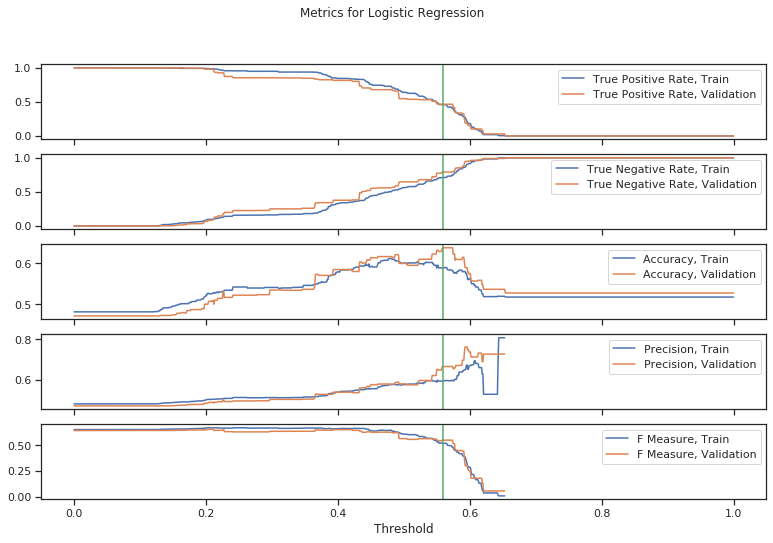

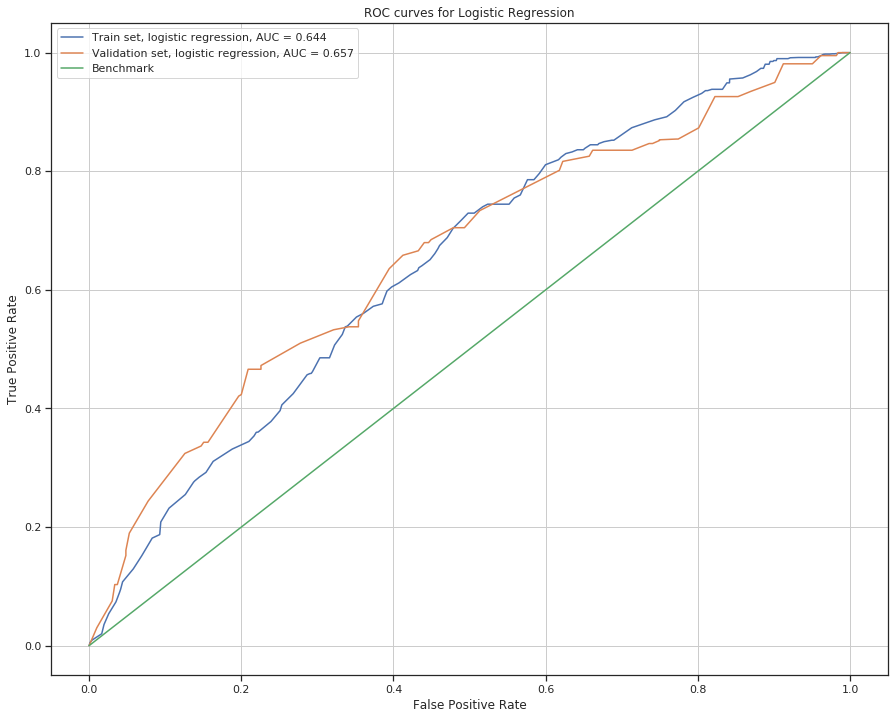

t* = 0.559
------------------
------------------
Train set
------------------
Accuracy (t=t*): 0.59
Accuracy (t=0.5): 0.6
------------------
Precision (t=t*): 0.6
Precision (t=0.5): 0.58
------------------
F_measure (t=t*): 0.52
F_measure (t=0.5): 0.61
------------------
------------------
Validation set
------------------
Accuracy (t=t*): 0.64
Accuracy (t=0.5): 0.6
------------------
Precision (t=t*): 0.67
Precision (t=0.5): 0.58
------------------
F_measure (t=t*): 0.55
F_measure (t=0.5): 0.56
------------------
------------------


In [16]:
X_train = train_bin[weather_predictors]
y_train = train_bin['Success']
X_validation = validation_bin[weather_predictors]
y_validation = validation_bin['Success']

# Train logistic regression model on training data
log_model = LogisticRegression(solver="lbfgs")
log_model.fit(X_train, y_train)

# Predict probability of success
y_train_pred_prob = log_model.predict_proba(X_train)
y_validation_pred_prob  = log_model.predict_proba(X_validation)
y_test_pred_prod = log_model.predict_proba(X_test)

# Calculate matrics and AUC for train and validation sets
y_data = {'Train': [y_train, y_train_pred_prob], 'Validation': [y_validation, y_validation_pred_prob]}
n = 1001
xrange = np.linspace(0, 1, n)
TP = dict()
FP = dict()
TN = dict()
FN = dict()
AUC = dict()
FPR = dict()
TNR = dict()
TPR = dict()
accuracy = dict()
precision = dict()
F_measure = dict()
threshold_star = dict()

for data_type, data in y_data.items():
    TP[data_type] = np.zeros(n)
    FP[data_type] = np.zeros(n)
    TN[data_type] = np.zeros(n)
    FN[data_type] = np.zeros(n)
    
    # Calculate confusion matrix and metrics for each threshold
    for i, threshold in enumerate(xrange):
        y_pred = [1 if y[1] >= threshold else 0 for y in data[1]]
        conf_mat = confusion_matrix(data[0], y_pred)
        TP[data_type][i] = conf_mat[1, 1]
        FP[data_type][i] = conf_mat[0, 1]
        TN[data_type][i] = conf_mat[0, 0]
        FN[data_type][i] = conf_mat[1, 0]

    # Calculate metrics
    TPR[data_type] = TP[data_type] / (TP[data_type] + FN[data_type]) # Sensitivity
    TNR[data_type] = TN[data_type] / (TN[data_type] + FP[data_type]) # Specificity
    FPR[data_type] = np.ones(n) - TNR[data_type]
    accuracy[data_type] = (TP[data_type] + TN[data_type]) / (TP[data_type] + FP[data_type] + TN[data_type] + FN[data_type])
    precision[data_type] = TP[data_type] / (TP[data_type] + FP[data_type])
    F_measure[data_type] = (2 * precision[data_type] * TPR[data_type]) / (precision[data_type] + TPR[data_type])

    # Calculate AUC of ROC
    AUC[data_type] = metrics.roc_auc_score(data[0], [y[1] for y in data[1]])

    
# Find threshold that maximises accuracy for validation data
t_index = np.argmax(accuracy['Validation'])
default_index = np.argwhere(xrange==0.5)[0][0]
threshold_star = xrange[t_index]

# Print metrics vs threshold
fig, axes = plt.subplots(5, 1, figsize=(13,8), sharex=True)
for data_type, data in y_data.items():
    axes[0].plot(xrange, TPR[data_type], label=f'True Positive Rate, {data_type}')
    axes[1].plot(xrange, TNR[data_type], label=f'True Negative Rate, {data_type}')
    axes[2].plot(xrange, accuracy[data_type], label=f'Accuracy, {data_type}')
    axes[3].plot(xrange, precision[data_type], label=f'Precision, {data_type}')
    axes[4].plot(xrange, F_measure[data_type], label=f'F Measure, {data_type}')
for ax in axes:
    ax.axvline(x=threshold_star, color='g')
    ax.legend()

plt.xlabel('Threshold')
fig.suptitle(f'Metrics for Logistic Regression')
plt.show()
    

# Plot ROC curves
fig, ax1 = plt.subplots(figsize=(15,12))
for data_type, data in y_data.items():
    ax1.plot(FPR[data_type], TPR[data_type], label=f'{data_type} set, logistic regression, AUC = {round(AUC[data_type], 3)}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curves for Logistic Regression')
ax1.plot(xrange, xrange, label='Benchmark')
plt.legend()
plt.grid()
plt.show()


# Print metrics at T* and 0.5
print(f't* = {threshold_star}')
print('------------------')
print('------------------')
for data_type, data in y_data.items():
    print(f'{data_type} set')
    print('------------------')
    print(f'Accuracy (t=t*): {round(accuracy[data_type][t_index], 2)}')
    print(f'Accuracy (t=0.5): {round(accuracy[data_type][default_index], 2)}')
    print('------------------')
    print(f'Precision (t=t*): {round(precision[data_type][t_index], 2)}')
    print(f'Precision (t=0.5): {round(precision[data_type][default_index], 2)}')
    print('------------------')
    print(f'F_measure (t=t*): {round(F_measure[data_type][t_index], 2)}')    
    print(f'F_measure (t=0.5): {round(F_measure[data_type][default_index], 2)}')
    print('------------------')
    print('------------------')

Based on the printed results above for accuracy, precision and f_measure for threshold=0.5 and threshold=t*, the accuracy and precision for the validation sets for t=t* is better than that of t=0.5, with the F_measure decreasing by a very small amount. Thus, choosing t to be t*, we would expect the model to perform better in out-of-sample data than with t=0.5.

## 2.2.3
Now, a Naive Bayes (Guassian) classifier is fit on the training data. As before, the same analysis is repeated using this classifier:

The predictions for the training and validation sets are given. Using these, different error metrics using the confusion matrices are plotted over the space of threhsolds for classifying success/failure of climbs. These are local measures of error (they depend on the threshold). The Receiver Operating Characteristic curves are plotted, and have AUCs of around 0.65 > 0.5. This is a global measure of error, and suggests our model performs better than random, but not perfectly, on predicting the success/failures of individual climbs based on the weather data. 

We can choose an optimal value for the threhold to maximise, say, the accuracy metric. The accuracy measure is chosen in this case as it is simple and easy to interpret (the number of correct classifications over all classifications). In this case, this threshold is calculated and is plotted across the graphs of the five local error measures.

/home/leon/Desktop/ic/M3A50/projects/python/env/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide
/home/leon/Desktop/ic/M3A50/projects/python/env/lib/python3.6/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide
/home/leon/Desktop/ic/M3A50/projects/python/env/lib/python3.6/site-packages/ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide


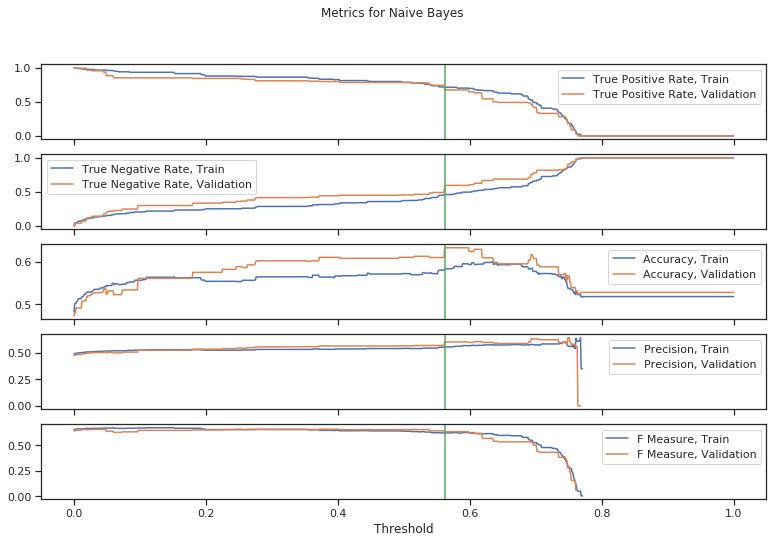

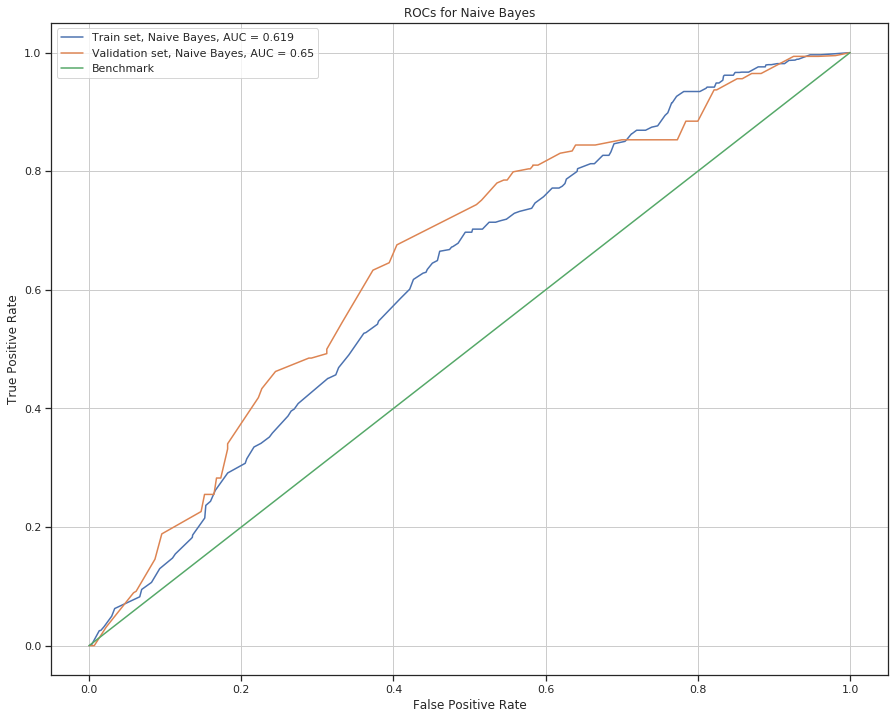

t* = 0.562
------------------
------------------
Train set
------------------
Accuracy (t=t*): 0.58
Accuracy (t=0.5): 0.57
------------------
Precision (t=t*): 0.55
Precision (t=0.5): 0.54
------------------
F_measure (t=t*): 0.62
F_measure (t=0.5): 0.64
------------------
------------------
Validation set
------------------
Accuracy (t=t*): 0.63
Accuracy (t=0.5): 0.61
------------------
Precision (t=t*): 0.6
Precision (t=0.5): 0.56
------------------
F_measure (t=t*): 0.64
F_measure (t=0.5): 0.66
------------------
------------------


In [17]:
# Train naive Bayes model on training data
bayes_model = GaussianNB()
bayes_model.fit(X_train, y_train)

# Predict probability of success
y_train_pred_prob = bayes_model.predict_proba(X_train)
y_validation_pred_prob  = bayes_model.predict_proba(X_validation)
y_test_pred_prod = bayes_model.predict_proba(X_test)

# Calculate matrics and AUC for train and validation sets
y_data = {'Train': [y_train, y_train_pred_prob], 'Validation': [y_validation, y_validation_pred_prob]}
n = 1001
xrange = np.linspace(0, 1, n)
TP = dict()
FP = dict()
TN = dict()
FN = dict()
AUC = dict()
FPR = dict()
TNR = dict()
TPR = dict()
accuracy = dict()
precision = dict()
F_measure = dict()
threshold_star = dict()

for data_type, data in y_data.items():
    TP[data_type] = np.zeros(n)
    FP[data_type] = np.zeros(n)
    TN[data_type] = np.zeros(n)
    FN[data_type] = np.zeros(n)
    
    # Calculate confusion matrix and metrics for each threshold
    for i, threshold in enumerate(xrange):
        y_pred = [1 if y[1] >= threshold else 0 for y in data[1]]
        conf_mat = confusion_matrix(data[0], y_pred)
        TP[data_type][i] = conf_mat[1, 1]
        FP[data_type][i] = conf_mat[0, 1]
        TN[data_type][i] = conf_mat[0, 0]
        FN[data_type][i] = conf_mat[1, 0]

    # Calculate metrics
    TPR[data_type] = TP[data_type] / (TP[data_type] + FN[data_type]) # Sensitivity
    TNR[data_type] = TN[data_type] / (TN[data_type] + FP[data_type]) # Specificity
    FPR[data_type] = np.ones(n) - TNR[data_type]
    accuracy[data_type] = (TP[data_type] + TN[data_type]) / (TP[data_type] + FP[data_type] + TN[data_type] + FN[data_type])
    precision[data_type] = TP[data_type] / (TP[data_type] + FP[data_type])
    F_measure[data_type] = (2 * precision[data_type] * TPR[data_type]) / (precision[data_type] + TPR[data_type])

    # Calculate AUC of ROC
    AUC[data_type] = metrics.roc_auc_score(data[0], [y[1] for y in data[1]])
    
# Find threshold that maximises accuracy for validation data
t_index = np.argmax(accuracy['Validation'])
default_index = np.argwhere(xrange==0.5)[0][0]
threshold_star = xrange[t_index]

# Print metrics vs threshold
fig, axes = plt.subplots(5, 1, figsize=(13,8), sharex=True)
for data_type, data in y_data.items():
    axes[0].plot(xrange, TPR[data_type], label=f'True Positive Rate, {data_type}')
    axes[1].plot(xrange, TNR[data_type], label=f'True Negative Rate, {data_type}')
    axes[2].plot(xrange, accuracy[data_type], label=f'Accuracy, {data_type}')
    axes[3].plot(xrange, precision[data_type], label=f'Precision, {data_type}')
    axes[4].plot(xrange, F_measure[data_type], label=f'F Measure, {data_type}')
for ax in axes:
    ax.axvline(x=threshold_star, color='g')
    ax.legend()

plt.xlabel('Threshold')
fig.suptitle(f'Metrics for Naive Bayes')
plt.show()

# Plot ROC curves
fig, ax1 = plt.subplots(figsize=(15,12))
for data_type, data in y_data.items():
    ax1.plot(FPR[data_type], TPR[data_type], label=f'{data_type} set, Naive Bayes, AUC = {round(AUC[data_type], 3)}')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROCs for Naive Bayes')
ax1.plot(xrange, xrange, label='Benchmark')
plt.legend()
plt.grid()
plt.show()

# Print metrics at T* and 0.5
print(f't* = {threshold_star}')
print('------------------')
print('------------------')
for data_type, data in y_data.items():
    print(f'{data_type} set')
    print('------------------')
    print(f'Accuracy (t=t*): {round(accuracy[data_type][t_index], 2)}')
    print(f'Accuracy (t=0.5): {round(accuracy[data_type][default_index], 2)}')
    print('------------------')
    print(f'Precision (t=t*): {round(precision[data_type][t_index], 2)}')
    print(f'Precision (t=0.5): {round(precision[data_type][default_index], 2)}')
    print('------------------')
    print(f'F_measure (t=t*): {round(F_measure[data_type][t_index], 2)}')    
    print(f'F_measure (t=0.5): {round(F_measure[data_type][default_index], 2)}')
    print('------------------')
    print('------------------')

Again, as before, we reach the same conclusion as in the logistic regression analysis:

Based on the printed results above for accuracy, precision and f_measure for threshold=0.5 and threshold=t*, the accuracy and precision for the validation sets for t=t* is better than that of t=0.5, with the F_measure decreasing by a small amount. Thus, choosing t to be t*, we would expect the model to perform better in out-of-sample data than with t=0.5.